# UTCI changes over time in specific regions
Code by Robin Lamboll. 
This notebook subvidides the UTCI data into specific regions, and calculates statistics on the inhabited parts of those regions

In [1]:
# Import needed packages
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import pandas as pd
import regionmask
import xarray as xr

In [2]:
# Import the data
folder = "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly95pc/HadGEM3-GC31-LL/"
output_folder = "../results/"
subfolders = os.listdir(folder)
print(subfolders)
def convert_kelvin(x):
    return x - 273.15

['historical', 'ssp126', 'ssp245', 'ssp585']


In [3]:
# Load example data.
subfolder = subfolders[1]
ssfolders = os.listdir(os.path.join(folder, subfolder))
print(ssfolders)
ssfolder = ssfolders[0]
data = xr.open_mfdataset(
    os.path.join(folder, subfolder, ssfolder, "*.nc"), concat_dim="time", engine="netcdf4",
)
resample = data.resample(time="M").mean()

['r1i1p1f3']


In [4]:
# Load population data and 
popdata = pd.read_csv(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/population_data/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.asc", 
    header=None, sep=" ", skiprows=range(6), na_values=-9999
)
popdata = popdata.iloc[:, :-1]
popdata = popdata.iloc[::-1, :]
popdata.columns = resample.lon.values
popdata_xr = popdata.set_index(resample.lat.values, drop=True)
popdata_xr = xr.DataArray(popdata, dims=("lat", "lon"))
popdata_xr = popdata_xr.assign_coords(lat=resample.lat.values)
popdata_xr = popdata_xr.assign_coords(lon=resample.lon.values)
popdata_xr

<xarray.DataArray (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

# Plot the data to check that we are investigating the region we want to

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

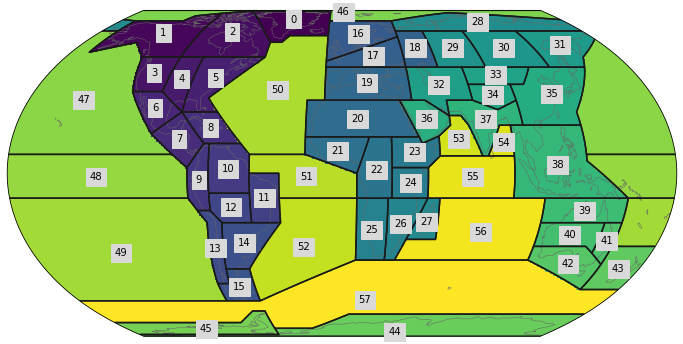

In [5]:
mask = regionmask.defined_regions.ar6.all.mask(resample)
proj = ccrs.EqualEarth()
f = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=proj)
mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
regionmask.defined_regions.ar6.all.plot(
    ax=ax, coastlines=True
)

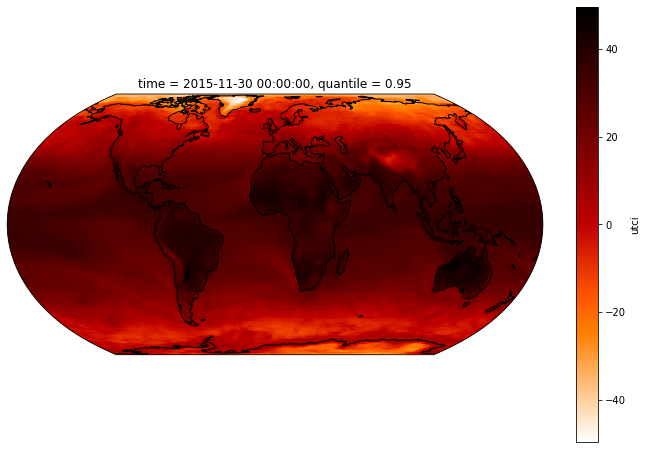

In [6]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

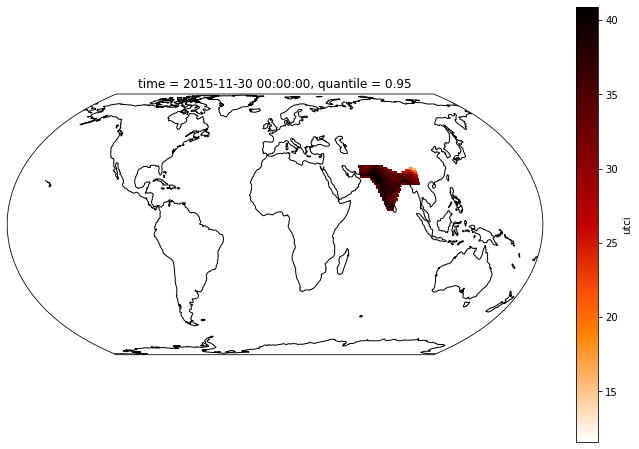

In [7]:
indiaMask = 37
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci.where(mask==indiaMask)-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

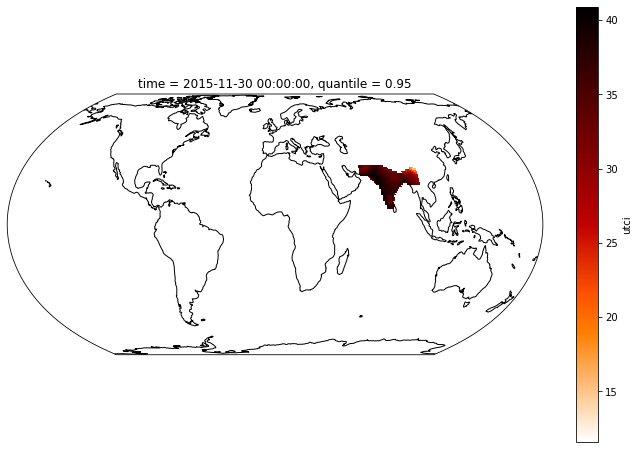

In [8]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci.where((mask==indiaMask) & (popdata_xr>0))-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines()

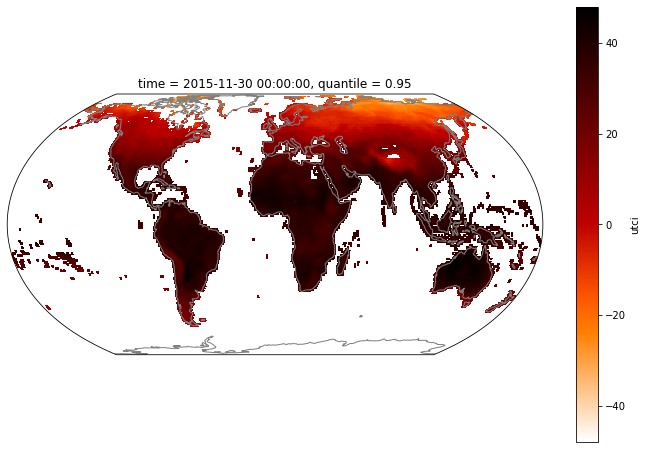

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
(resample.isel(time=10).utci.where(popdata_xr>0)-273.15).plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True, cmap="gist_heat_r"
)
ax.coastlines(color='grey')

# Calculate the regional values
Firstly calculate the impact on the Indian subcontinent and then on North Europe, where inhabited. 

In [10]:
masked_india = (resample.utci.where((mask==indiaMask) & (popdata_xr>0))-273.15).mean(["lat", "lon"]).to_dataframe()
masked_india

,quantile,utci
time,,
2015-01-30 00:00:00,0.95,30.182666
2015-02-30 00:00:00,0.95,31.782611
2015-03-30 00:00:00,0.95,36.378491
2015-04-30 00:00:00,0.95,40.605720
2015-05-30 00:00:00,0.95,43.142676
...,...,...
2100-09-30 00:00:00,0.95,39.867267
2100-10-30 00:00:00,0.95,40.897697
2100-11-30 00:00:00,0.95,38.588522


In [11]:
masked_india = masked_india[:-1]

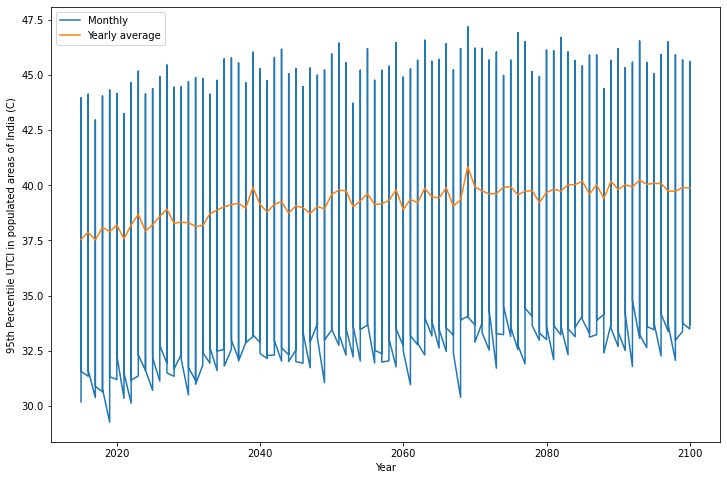

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.plot([i.year for i in masked_india.index], masked_india.utci)
plt.plot(masked_india.groupby([i.year for i in masked_india.index]).utci.mean())
plt.xlabel("Year")
plt.ylabel("95th Percentile UTCI in populated areas of India (C)")
plt.legend(["Monthly", "Yearly average"])
fig.savefig(os.path.join(output_folder, "IndiaYearlyAndMonthly95thUTCI.png"))

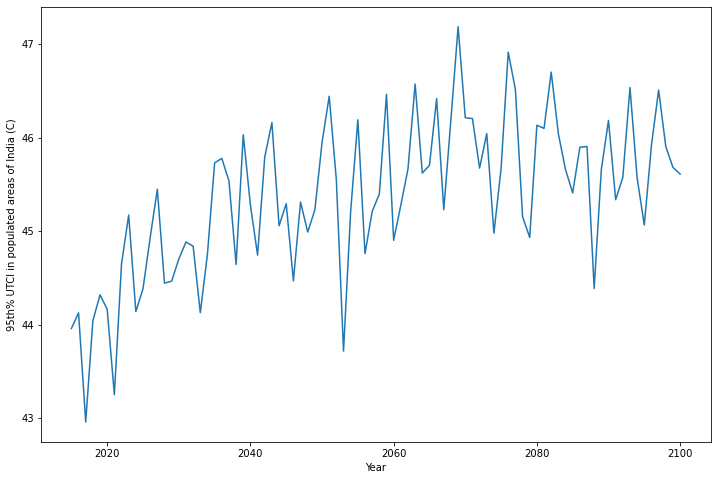

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.plot(masked_india.groupby([i.year for i in masked_india.index]).utci.max())
plt.xlabel("Year")
plt.ylabel("95th% UTCI in populated areas of India (C)")
fig.savefig(os.path.join(output_folder, "IndiaYearly95thUTCI-yearmax.png"))

In [15]:
NorthEuropeMask = 16
masked_europe = (resample.utci.where((mask==NorthEuropeMask) & (popdata_xr>0))-273.15).mean(["lat", "lon"]).to_dataframe()
masked_europe = masked_europe[:-1]

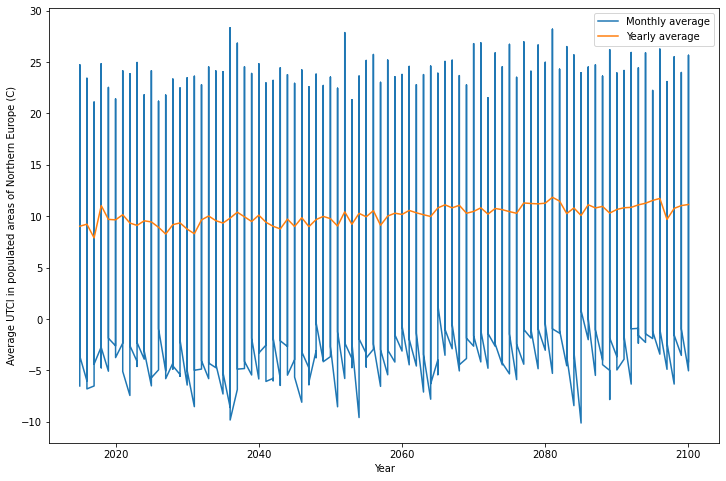

In [16]:
fig = plt.figure(figsize=(12, 8))
plt.plot([i.year for i in masked_europe.index], masked_europe.utci)
plt.plot(masked_europe.groupby([i.year for i in masked_europe.index]).utci.mean())
plt.xlabel("Year")
plt.ylabel("Average UTCI in populated areas of Northern Europe (C)")
plt.legend(["Monthly average", "Yearly average"])
fig.savefig(os.path.join(output_folder, "NorthEuropeYearlyAndMonthly95thpcUTCI.png"))

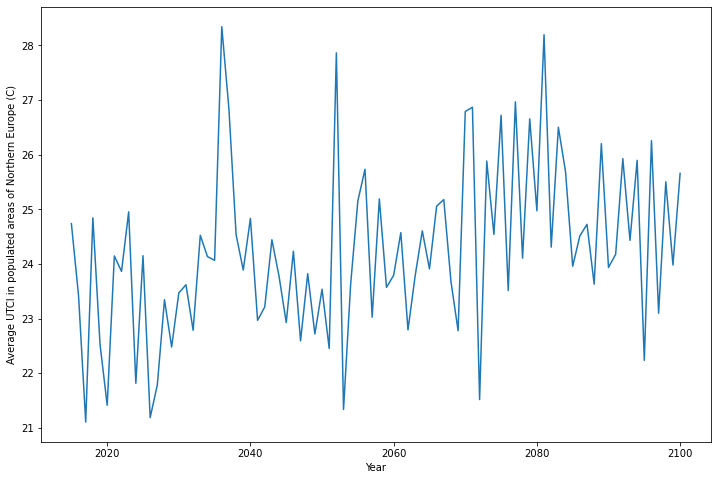

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.plot(masked_europe.groupby([i.year for i in masked_europe.index]).utci.max())
plt.xlabel("Year")
plt.ylabel("Average UTCI in populated areas of Northern Europe (C)")
fig.savefig(os.path.join(output_folder, "NorthEuropeYearly95thpcUTCI-yearmax.png"))

['r1i1p1f3']
['r1i1p1f3']
['r1i1p1f3']


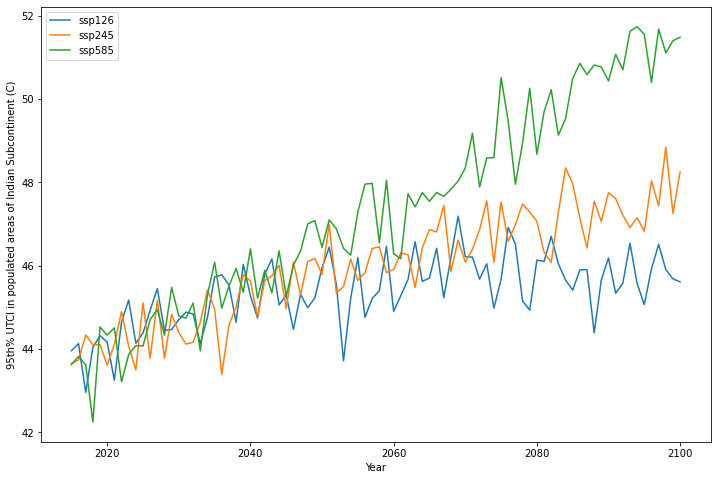

In [19]:
fig = plt.figure(figsize=(12, 8))
for subfolder in subfolders[1:]:
    ssfolders = os.listdir(os.path.join(folder, subfolder))
    print(ssfolders)
    for ssfolder in ssfolders:
        # files = os.listdir(os.path.join(folder, subfolder, ssfolder))
        # print(files)
        data = xr.open_mfdataset(
            os.path.join(folder, subfolder, ssfolder, "*.nc"), concat_dim="time", engine="netcdf4",
            #chunks={'lat': 30, 'lon': 30, 'time': -1}
        )
        resample = data.resample(time="M").mean()
        division_len = 130
        tmax = len(resample.time)
        masked_india = (resample.utci.where((mask==indiaMask) & (popdata_xr>0))-273.15).mean(["lat", "lon"]).to_dataframe()
        masked_india = masked_india[:-1]
        
        plt.plot(masked_india.groupby([i.year for i in masked_india.index]).utci.max())
plt.xlabel("Year")
plt.ylabel("95th% UTCI in populated areas of Indian Subcontinent (C)")
plt.legend(subfolders[1:])
fig.savefig(os.path.join(output_folder, "IndiaYearly95thpcUTCIMultimodel-yearmax.png"))

['r1i1p1f3']
['r1i1p1f3']
['r1i1p1f3']


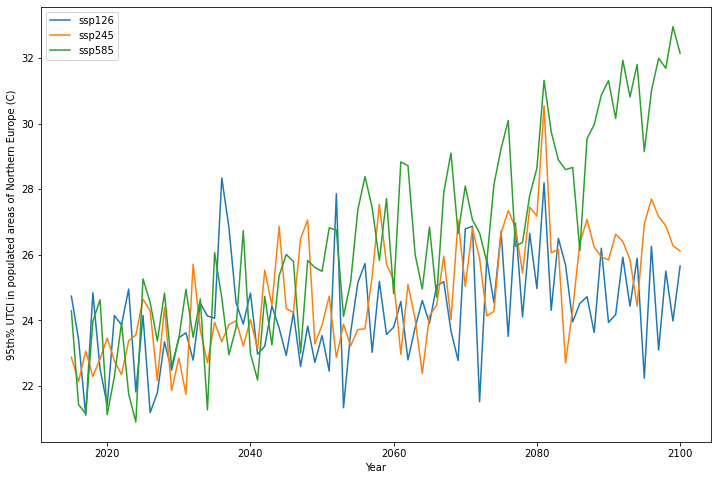

In [20]:
fig = plt.figure(figsize=(12, 8))
for subfolder in subfolders[1:]:
    ssfolders = os.listdir(os.path.join(folder, subfolder))
    print(ssfolders)
    for ssfolder in ssfolders:
        # files = os.listdir(os.path.join(folder, subfolder, ssfolder))
        # print(files)
        data = xr.open_mfdataset(
            os.path.join(folder, subfolder, ssfolder, "*.nc"), concat_dim="time", engine="netcdf4",
            #chunks={'lat': 30, 'lon': 30, 'time': -1}
        )
        resample = data.resample(time="M").mean()
        division_len = 130
        tmax = len(resample.time)
        masked_europe = (resample.utci.where((mask==NorthEuropeMask) & (popdata_xr>0))-273.15).mean(["lat", "lon"]).to_dataframe()
        masked_europe = masked_europe[:-1]
        
        plt.plot(masked_europe.groupby([i.year for i in masked_europe.index]).utci.max())
plt.xlabel("Year")
plt.ylabel("95th% UTCI in populated areas of Northern Europe (C)")
plt.legend(subfolders[1:])
fig.savefig(os.path.join(output_folder, "NEuropeYearly95thpcUTCIMultimodel-yearmax.png"))